# Koristi CPU?
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


Bolje koristiti GPU, ovo samo da vidim razliku u izvođenju.

In [1]:
import numpy as np
import pandas as pd


from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Conv3D, Conv3DTranspose, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Input, BatchNormalization, Dropout, Lambda, Bidirectional
from keras.layers import CuDNNLSTM, Reshape, PReLU, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import load_model

import keras.backend as K

import matplotlib.pyplot as plt

import time 
import tensorflow as tf
from sklearn import metrics
import pickle
import os
import scipy.io as sio

Using TensorFlow backend.


In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
np.random.seed(5)
tf.set_random_seed(5)

In [4]:
# definiranje dodatnih metrika
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# LOAD voxel DATA

Učitavanje IKEA modela za testiranje, dostupni u https://github.com/rohitgirdhar/GenerativePredictableVoxels/tree/master/dataset/IKEA/Voxels

In [5]:
vox_data = []

In [6]:
data_dir = "C:\programiranje\diplprojekt\GenerativePredictableVoxels-master\dataset\IKEA\Voxels"

In [7]:
for file in os.listdir(data_dir):
    vox_data.append(sio.loadmat(data_dir+"/"+file)["grid"])

In [8]:
np.shape(vox_data)

(225, 20, 20, 20)

In [9]:
train_X = np.array(vox_data[:220])
test_X = np.array(vox_data[220:])

In [10]:
np.shape(train_X)

(220, 20, 20, 20)

In [11]:
np.shape(test_X)[0]

5

In [12]:
train_X = np.reshape(train_X, (220, 20, 20, 20, 1))

In [13]:
test_X = np.reshape(test_X, (np.shape(test_X)[0], 20, 20, 20, 1))

# MODEL AUTOENCODER

Jednostavni model autoencodera.
Nisam prije radio s autoencoderima pa da napravim jedan jednostavan model koji se brzo trenira i da vidim jel radi sve. (Radio sam ga po uzoru na autoencoder u članku)

In [14]:
input_vox = Input(shape=(20,20,20,1,))

conv1 = Conv3D(16, 7,  activation = "relu")(input_vox)
conv2 = Conv3D(32, 3, activation = "relu")(conv1)

flat = Flatten()(conv2)
dens = Dense(32)(flat)

# jer je 12*12*12 = 1728
dens2 = Dense(1728)(dens)

# namješteno tak da zadnji layer bude shape (20, 20, 20)
reshp = Reshape((12, 12, 12, -1))(dens2)

deconv1 = Conv3DTranspose(32, 3, activation = "relu")(reshp)
deconv2 = Conv3DTranspose(16, 7, activation = "relu")(deconv1)
out = Conv3DTranspose(1, 1, activation = "sigmoid")(deconv2)

autoencoder = Model(inputs = input_vox, outputs = out)
autoencoder.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics =["accuracy", precision])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 20, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 14, 16)    5504      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    13856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1769504   
_________________________________________________________________
dense_2 (Dense)              (None, 1728)              57024     
_________________________________________________________________
reshape_1 (Reshape)          (None, 12, 12, 12, 1)     0         
__________

# Loadanje prethodno treniranog modela

Kako sam ga već istrenirao učitavam gotov model.

In [55]:
# loadanje vec istreniranog mojeg modela
# custom objects jer precision metrica nije defaultna
autoencoder = load_model("autoencoder_simple.h5", custom_objects={'precision': precision})

In [56]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 20, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 14, 16)    5504      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    13856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1769504   
_________________________________________________________________
dense_2 (Dense)              (None, 1728)              57024     
_________________________________________________________________
reshape_1 (Reshape)          (None, 12, 12, 12, 1)     0         
__________

# Cpu treniranje.... sporo.. 

In [17]:
# ETA: 7:35 za 1 epohu, 220 train data samplova
autoencoder.fit(train_X, train_X, batch_size = 1, verbose =1, shuffle = True, epochs = 3)

Epoch 1/3
  5/220 [..............................] - ETA: 7:35 - loss: 0.8127 - acc: 0.8159 - precision: 0.0000e+00

KeyboardInterrupt: 

In [31]:
test_X.shape

(5, 20, 20, 20, 1)

In [29]:
test_X[0].shape

(20, 20, 20, 1)

# Predikcija za prvi test sample

In [29]:
predikt = autoencoder.predict(np.reshape(test_X[0], (1, 20, 20, 20, 1)))

In [30]:
predikt.shape

(1, 20, 20, 20, 1)

# GPU treniranje

In [15]:
# C:\Program Files\NVIDIA Corporation\NVSMI   "nvidia-smi -l 1"  za gpu utilization, osvjezava svake sekunde, bolji je utilization kad je 
# veca mreza tj. veci kapacitet mreze i kada je veci batch size

In [15]:
autoencoder.fit(train_X, train_X, batch_size = 32, verbose =1, shuffle = True, epochs = 200)

Epoch 1/200
220/220 [==============================] - 5s 24ms/step - loss: 0.7198 - acc: 0.7960 - precision: 0.0254
Epoch 2/200
220/220 [==============================] - 1s 4ms/step - loss: 0.5191 - acc: 0.8690 - precision: 0.0000e+00
Epoch 3/200
220/220 [==============================] - 1s 4ms/step - loss: 0.4376 - acc: 0.8690 - precision: 0.0000e+00
Epoch 4/200
220/220 [==============================] - 1s 4ms/step - loss: 0.4157 - acc: 0.8690 - precision: 0.0000e+00
Epoch 5/200
220/220 [==============================] - 1s 4ms/step - loss: 0.4002 - acc: 0.8690 - precision: 0.0000e+00
Epoch 6/200
220/220 [==============================] - 1s 4ms/step - loss: 0.3946 - acc: 0.8690 - precision: 0.0000e+00
Epoch 7/200
220/220 [==============================] - 1s 4ms/step - loss: 0.3743 - acc: 0.8690 - precision: 0.0000e+00
Epoch 8/200
220/220 [==============================] - 1s 4ms/step - loss: 0.3674 - acc: 0.8690 - precision: 0.0000e+00
Epoch 9/200
220/220 [======================

In [17]:
history = _

In [23]:
treniranje_metrike = history.history
treniranje_metrike.keys()

dict_keys(['loss', 'acc', 'precision'])

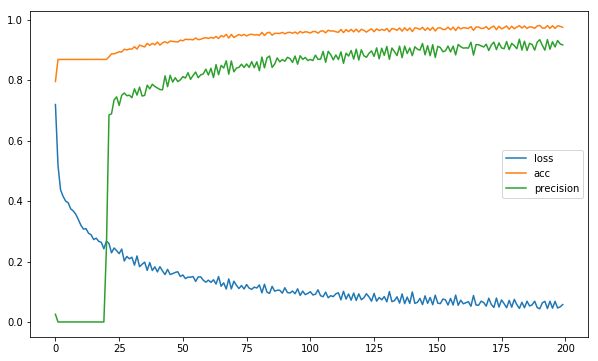

In [28]:
plt.figure(figsize = (10,6))
plt.plot(treniranje_metrike["loss"], label = "loss")
plt.plot(treniranje_metrike["acc"], label = "acc")
plt.plot(treniranje_metrike["precision"], label = "precision")
plt.legend()

In [31]:
predikt = autoencoder.predict(np.reshape(test_X[0], (1,20,20,20,1)))

In [32]:
autoencoder.evaluate(test_X, test_X)

5/5 [==============================] - 0s 51ms/step


[0.3490695357322693, 0.942175030708313, 0.7771697044372559]

In [33]:
np.histogram(predikt.flatten())

(array([7423,   36,   23,   13,   10,   13,    7,   12,   12,  451],
       dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

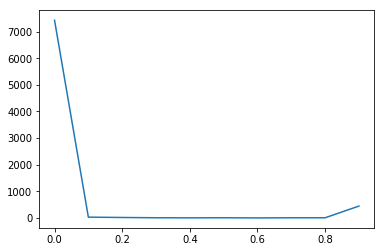

In [34]:
plt.figure()
plt.plot(np.histogram(predikt.flatten())[1][:-1], np.histogram(predikt.flatten())[0])

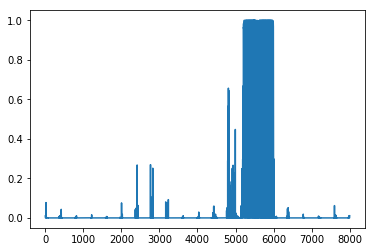

In [35]:
plt.figure()
plt.plot(predikt.flatten())

In [36]:
predikt_round = np.round(predikt)

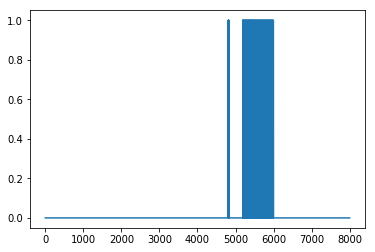

In [37]:
plt.figure()
plt.plot(predikt_round.flatten())

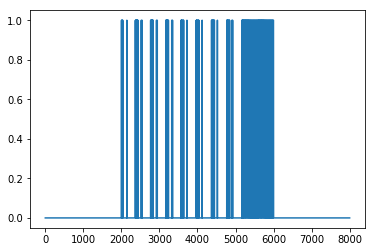

In [38]:
plt.figure()
plt.plot(test_X[0].flatten())

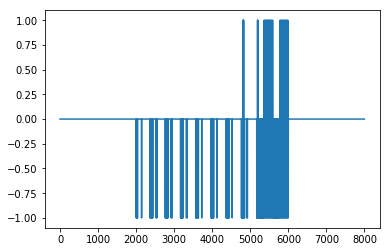

In [39]:
plt.figure()
plt.plot(predikt_round.flatten()-test_X[0].flatten())

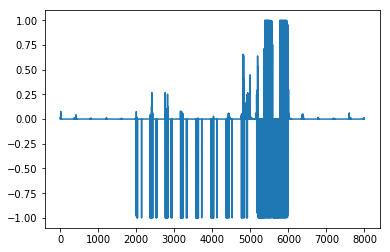

In [40]:
plt.figure()
plt.plot(predikt.flatten()-test_X[0].flatten())

In [41]:
np.std(predikt.flatten()-test_X[0].flatten())

0.17875667

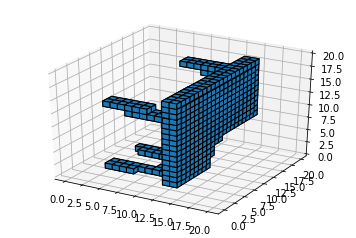

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(np.reshape(test_X[0], (20,20,20)), edgecolor='k');

In [43]:
predikt.shape

(1, 20, 20, 20, 1)

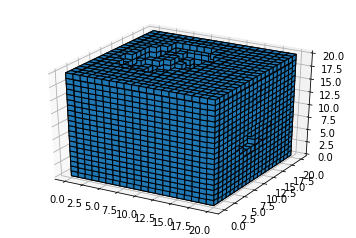

In [44]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(np.reshape(predikt, (20,20,20)), edgecolor='k');

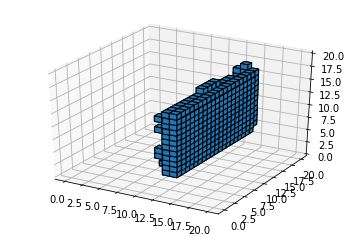

In [45]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(np.reshape(predikt_round, (20,20,20)), edgecolor='k');

In [86]:
autoencoder.history.history.keys()

dict_keys(['loss', 'acc', 'precision'])

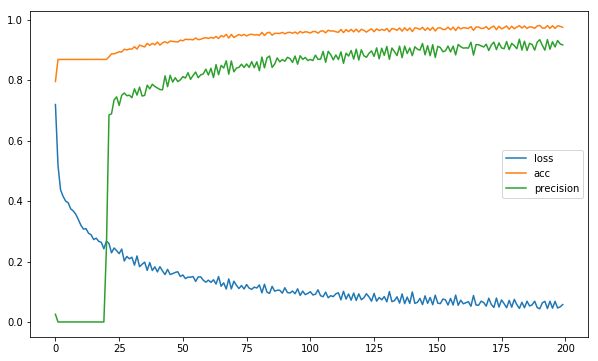

In [54]:
plt.figure(figsize = (10,6))
plt.plot(autoencoder.history.history["loss"], label = "loss")
plt.plot(autoencoder.history.history["acc"], label = "acc")
plt.plot(autoencoder.history.history["precision"], label = "precision")
plt.legend()

In [48]:
autoencoder.history.history.keys()

dict_keys(['loss', 'acc', 'precision'])

In [49]:
train_predikt = autoencoder.predict(train_X)

In [50]:
train_predikt.shape

(220, 20, 20, 20, 1)

In [51]:
train_X.dtype

dtype('uint8')

In [52]:
train_predikt.dtype

dtype('float32')

In [53]:
metrics.average_precision_score(train_X.flatten(), train_predikt.flatten())

0.9839656517150217

# Sejvanje keras modela autoencodera

In [46]:
autoencoder.save("autoencoder_simple.h5")

# U ČLANKU MODEL AUTOENCODER

Arhitektura autoencodera prema članku. Autoencoder su prvo sam trenirali 200 epoha.

In [14]:
input_vox = Input(shape=(20,20,20,1,))

conv1 = Conv3D(96, 7)(input_vox)
act1 = PReLU()(conv1)
conv2 = Conv3D(256, 5)(act1)
act2 = PReLU()(conv2)
conv3 = Conv3D(384, 3)(act2)
act3 = PReLU()(conv3)
conv4 = Conv3D(256, 3)(act3)
act4 = PReLU()(conv4)

# embedding layer neamaju aktivacije!

# inner product u cafffeu implicitno flattena..
flat = Flatten()(act4)
dens = Dense(64, name = "dense_layer")(flat)

# 6*6*6 = 216
dens2 = Dense(216)(dens)
# 6,6,6 jer to rezultira izlazom "out" 20,20,20
reshp = Reshape((6, 6, 6, -1))(dens2)

deconv1 = Conv3DTranspose(256, 3)(reshp)
dact1 = PReLU()(deconv1)
deconv2 = Conv3DTranspose(384, 3)(dact1)
dact2 = PReLU()(deconv2)
deconv3 = Conv3DTranspose(256, 5)(dact2)
dact3 = PReLU()(deconv3)
deconv4 = Conv3DTranspose(96, 7)(dact3)
dact4 = PReLU()(deconv4)
out = Conv3DTranspose(1, 1, activation = "sigmoid")(dact4)

autoencoder = Model(inputs = input_vox, outputs = out)
autoencoder.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics =["accuracy", precision])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 20, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 14, 96)    33024     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 14, 14, 14, 96)    263424    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 10, 10, 256)   3072256   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 10, 10, 10, 256)   256000    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 384)      2654592   
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 8, 8, 8, 384)      196608    
__________

In [17]:
16000/220

72.72727272727273

In [16]:
# ETA: 1:43 za 1 epohu, jer je 220 train primjera, u članku 16k training samplova (73x više)!
autoencoder.fit(train_X, train_X, batch_size = 4, verbose =1, shuffle = True, epochs = 20)

Epoch 1/20
 12/220 [>.............................] - ETA: 1:05 - loss: 1.9911 - acc: 0.8765 - precision: 0.0000e+00

KeyboardInterrupt: 

# IMAGE REGRESSION NET

Arhitektura i loss funkcija (članak) za image regression network. AlexNet https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637

In [5]:
 # loss func
def euclidean_distance_loss(y_true, y_pred): 
    """ Euclidean distance loss https://en.wikipedia.org/wiki/Euclidean_distance 
    :param y_true: TensorFlow/Theano tensor 
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true :return: float """ 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [6]:
# img shape???  227x227 RGB u alexnetu, https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637
img_height, img_widght, channels = 227, 227, 3

In [8]:
input_img = Input(shape=(img_height,img_widght,channels,))

conv1 = Conv2D(filters = 96, kernel_size = 11, strides = (4,4), activation = "relu", name = "conv1")(input_img)
max_pool1 = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv1)
# ovdje ide LRN Caffe layer.. nema ekvivalenta u keras.. tj https://github.com/ckoren1975/Machine-learning/blob/master/googlenet_custom_layers.py
# batch norm umjesto? LRN nije koristen vise?
batch_norm1 = BatchNormalization()(max_pool1)

zero_pad2 = ZeroPadding2D(padding = (2,2))(batch_norm1)
conv2 = Conv2D(256, 5, activation = "relu", name = "conv2")(zero_pad2)

max_pool2 = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv2)
batch_norm2 = BatchNormalization()(max_pool2)

conv3 = Conv2D(384, 3, activation = "relu", padding = "same", name = "conv3")(batch_norm2)
conv4 = Conv2D(384, 3, activation = "relu", padding = "same", name = "conv4")(conv3)
conv5 = Conv2D(256, 3, activation = "relu", padding = "same", name = "conv5")(conv4)
max_pool2 = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv5)

#drop0 = Dropout(0.5)(max_pool2) #?? https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637

flat1 = Flatten()(max_pool2)
dens1 = Dense(4096, activation = "relu")(flat1)
drop1 = Dropout(0.5)(dens1)
dens2 = Dense(4096, activation = "relu")(drop1)
drop2 = Dropout(0.5)(dens2)

# ovdje se razlikuje od alexneta, nema aktivacije!
out_regress = Dense(64)(drop2)

img_regress = Model(inputs = input_img, outputs = out_regress)
img_regress.compile(loss=euclidean_distance_loss, optimizer='rmsprop', metrics =["accuracy", precision, 'mse', 'mae', 'mape', 'cosine'])
img_regress.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 256)       0         
__________